In [1]:
# read and convert MVO data to MiniSEED
import os
import glob
import obspy
from SAM import RSAM
MVOdatadir = '/data/Montserrat/LaharStudy/MVOdata'
mseeddir = os.path.join(MVOdatadir, 'converted')
SDS_DIR = '/data/SDS'
SAM_DIR = '/data/SAM'
network = 'MV'

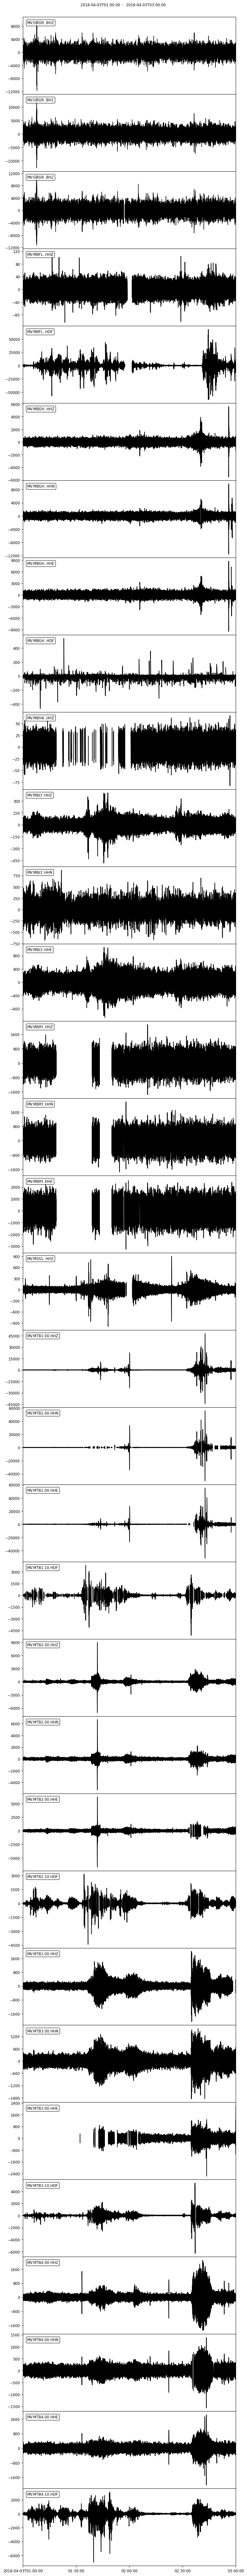

METRIC:  mean
nan
nan
129.38819416925998
4.3100813756251135
4.25644782312822
187.9565975734705
138.54597164969732
100.51483525827366
10.625587679154464
21.291198054202955
10.94406440205165
21.078816922687928
36.37613433141533
24.23330783980093
8.593800100804222
nan
21.560099141429824
12.174810680070019
44.747584644076916
40.87118475269906
9.40061631435265
361.0169490754517
1.5742547767374528
159.36654354560295
190.38596538499348
112.67114798542387
35.989691938338225
41.043665907233894
13.52161142869022
31.84527666569951
27.95699539571712
49.84905308747379
21.069770754287408


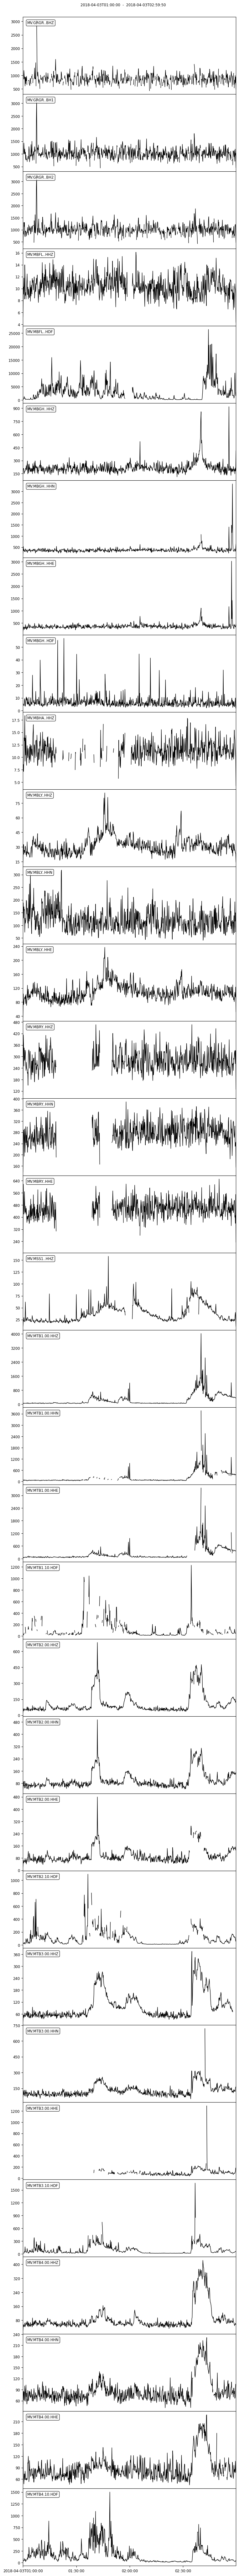

In [17]:
import numpy as np
def piecewise_detrend(st, null_value=0, fill_value=np.nan, detrend='linear', highpass=0.02): 
    # takes a Stream object nominally from an SDSclient that has gaps marked by zeros, and applies

    if not detrend and not highpass:
        return

    # split into contiguous segments
    isSplit = False
    for tr in st:
        if np.any(tr.data == null_value):
            tr.data = np.ma.masked_where(tr.data == null_value, tr.data)
            all_traces = tr.split()
            isSplit=True
            st.remove(tr)
            for newtr in all_traces:
                st.append(newtr)

    # detrend
    if detrend:
        st.detrend(detrend)        
    
    # taper and high filter filter each piece
    if highpass:
        st.taper(max_percentage=0.1, max_length=1/highpass)
        st.filter('highpass', freq=highpass, corners=2, zerophase=True)
    
    # recombine
    if isSplit:
        st.merge(method=0, fill_value=fill_value)

from obspy.clients.filesystem.sds import Client as sdsclient
def from_SDS(SDS_DIR, startTime, endTime, network, station='*', location='*', channel='[BHESCD]*', sampling_interval=60, plot_stream=False):
    mySDSclient = sdsclient(SDS_DIR, sds_type='D', format='MSEED', fileborder_seconds=30, fileborder_samples=5000)
    st = mySDSclient.get_waveforms(network, station, location, channel, startTime, endTime-0.004)
    piecewise_detrend(st, highpass=1/sampling_interval)
    if plot_stream:
        st.plot(equal_scale=False);
    rsamobj = RSAM(stream=st, sampling_interval=sampling_interval, filter=None)
    return rsamobj

startTime = obspy.core.UTCDateTime(2018,4,3,1,0,0)
numhours=2
endTime = startTime+numhours*3600-0.004
sampling_interval=10
rsamobj = from_SDS(SDS_DIR, startTime, endTime, network, sampling_interval=sampling_interval, plot_stream=True)
rsamobj.plot();